<a href="https://colab.research.google.com/github/irenegauna/BrainXrayAlzheimersClassifier/blob/main/AlzheimersClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
import json
import os
from zipfile import ZipFile
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### 1. Load Data

In [2]:
data=json.load(open("kaggle.json"))

In [3]:
data.keys()

dict_keys(['username', 'key'])

In [4]:
os.environ["KAGGLE_USERNAME"]=data["username"]
os.environ["KAGGLE_KEY"]=data["key"]

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d sachinkumar413/alzheimer-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset
License(s): copyright-authors
 61% 17.0M/28.0M [00:00<00:00, 63.3MB/s]
100% 28.0M/28.0M [00:00<00:00, 76.8MB/s]


In [7]:
!ls

alzheimer-mri-dataset.zip  kaggle.json	sample_data


In [7]:
with ZipFile("alzheimer-mri-dataset.zip","r") as zipi:
  zipi.extractall()

In [9]:
!ls

alzheimer-mri-dataset.zip  Dataset  kaggle.json  sample_data


In [77]:
X=[]
y=[]
df=[]

for label in os.listdir("Dataset"):
  for filename in os.listdir("Dataset/"+label):
    y.append(label)
    X.append(filename)
    df.append([filename,label])

### 2. Image preprocessing

In [9]:
#Copy of function we used once in class to convert images to arrays:
def image_to_array(fn):
    im = Image.open(fn).convert('RGB')
    if im.size[0] > im.size[1]:
        xstart = (im.size[0] - im.size[1]) // 2
        im = im.crop((xstart, 0, xstart + im.size[1], im.size[1]))
    else:
        ystart = (im.size[1] - im.size[0]) // 2
        im = im.crop((0, ystart, im.size[0], ystart + im.size[0]))
    im = im.resize((128, 128))
    return np.array(im)

In [78]:
print(len(y),len(df))

6400 6400


Our dataset has 6400 images with 128x128 pixels. We tried with all images but t's too much for google colab to handle when we want to perform the model. (We get a message error because we utilize all RAM available). So, we decided to reduce the data points

In [10]:
#Reduce data points:
X=[]
y=[]
df_less_data=[]

for label in os.listdir("Dataset"):
  i=0
  for filename in os.listdir("Dataset/"+label):
    if i<1001: #i<1001 in order to not have more than 1.000 images per category
      X.append(image_to_array("Dataset/"+label+"/"+filename))
      y.append(label)
      df_less_data.append([filename,label])
      i=i+1

### 3. Data Exploration

In [11]:
#Convert list to dataframe to analyze the data:
df=pd.DataFrame(df_less_data,columns=['Filename', 'Label'])
df.head()

,Filename,Label
0,moderate_24.jpg,Moderate_Demented
1,moderate_35.jpg,Moderate_Demented
2,moderate_56.jpg,Moderate_Demented
3,moderate_3.jpg,Moderate_Demented
4,moderate_60.jpg,Moderate_Demented


In [13]:
df.shape

(2962, 2)

<Axes: ylabel='Label'>

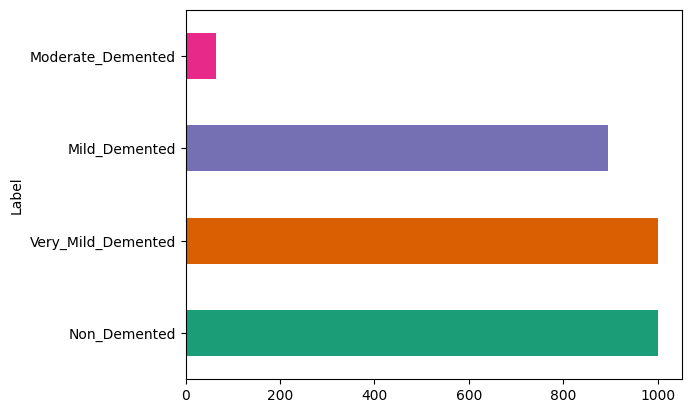

In [12]:
df["Label"].value_counts().plot.barh(color=sns.palettes.mpl_palette('Dark2'))

In [14]:
df["Label"].value_counts() #The data is imbalanced. Moderate_Demented will be difficult to predict correctly.

Label
Non_Demented          1001
Very_Mild_Demented    1001
Mild_Demented          896
Moderate_Demented       64
Name: count, dtype: int64

### Visualization of our images

In [15]:
def display(images, labels=None):
    plt.figure(figsize=(12, 4))
    n_images = min(5, len(images))
    for i in range(n_images):
        ax = plt.subplot(1, n_images, i + 1)
        plt.imshow(images[i])
        if labels is not None:
            plt.title(labels[i])
        plt.axis("off")

In [16]:
a=image_to_array("Dataset/Mild_Demented/mild.jpg")
b=image_to_array("Dataset/Very_Mild_Demented/verymild.jpg")
c=image_to_array("Dataset/Non_Demented/non.jpg")
d=image_to_array("Dataset/Moderate_Demented/moderate.jpg")
a.shape,b.shape

((128, 128, 3), (128, 128, 3))

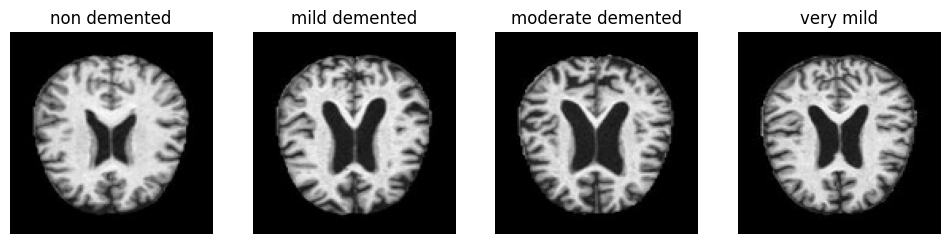

In [17]:
display([c,a,d,b], ["non demented","mild demented","moderate demented","very mild"])

The type of our data is:

In [18]:
print(type(y),type(X)) #lists

<class 'list'> <class 'list'>


In [19]:
X=np.vstack(X).reshape(len(X),128,128,3)
X=X/255.0
y=np.array(y)

Now data type is:

In [20]:
print(type(y),type(X)) #arrays

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


### 4. Split training and validation data

In [71]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2)
print(Xtrain.shape,ytrain.shape,Xtest.shape,ytest.shape)

(2369, 128, 128, 3) (2369,) (593, 128, 128, 3) (593,)


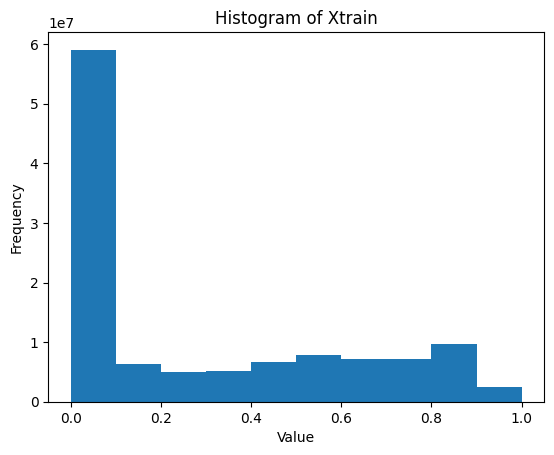

In [23]:
#Visualize our training data:
plt.hist(Xtrain.flatten(), bins=10)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Xtrain')
plt.show()
#There are a lot of empty values. So pixels which are "useless"

### 5. Train a Multinomial Logistic Regression Model

In [ ]:
'''model=LogisticRegression()
model.fit(Xtrain,ytrain)
pred=model.predict(Xtrain)
accuracy_score(pred,ytrain)'''
#this doesn't work since we have data points with 4 dimensions. Let's solve it

In [ ]:
#We solve it by flattening the data:

In [24]:
Xtrain_reshaped = Xtrain.reshape(Xtrain.shape[0], -1)
Xtest_reshaped = Xtest.reshape(Xtest.shape[0], -1)

print(Xtrain_reshaped.shape)
print(Xtest_reshaped.shape)

(2369, 49152)
(593, 49152)


In [25]:
model=LogisticRegression(max_iter=15, solver='saga',C=0.1) #regularization to decrease overfitting
model.fit(Xtrain_reshaped,ytrain)
pred=model.predict(Xtrain_reshaped)
accuracy_score(pred,ytrain)

#92% accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


0.9172646686365555

In [26]:
pred[0:15]

array(['Non_Demented', 'Mild_Demented', 'Non_Demented', 'Non_Demented',
       'Non_Demented', 'Mild_Demented', 'Mild_Demented', 'Mild_Demented',
       'Very_Mild_Demented', 'Mild_Demented', 'Mild_Demented',
       'Very_Mild_Demented', 'Very_Mild_Demented', 'Very_Mild_Demented',
       'Non_Demented'], dtype='<U18')

In [27]:
pred_test=model.predict(Xtest_reshaped)
accuracy_score(pred_test,ytest)
#Test accuracy is 80%
#We have overfitting. Let's see how we can solve it

0.8010118043844857

### 6. Try other models to reduce overfitting:

In [28]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=28)
model.fit(Xtrain_reshaped, ytrain)

pred_train = model.predict(Xtrain_reshaped)
train_accuracy = accuracy_score(pred_train, ytrain)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

Training Accuracy: 100.00%


In [29]:
pred_test = model.predict(Xtest_reshaped)
test_accuracy = accuracy_score(pred_test, ytest)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
#training accuracy is better than logistic regression but the overfitting is bigger

Test Accuracy: 79.09%


In [32]:
y_test=list(ytest)
print(classification_report(y_test,pred_test))
#Forest classifier model predicts moderate dementia with perfect precision, but recall is low at 57%. This suggests that the model misses almost the half of the actual moderate dementia cases. This is understandable since we have very few data points there in comparison to the other categories.

                    precision    recall  f1-score   support

     Mild_Demented       0.80      0.92      0.86       179
 Moderate_Demented       1.00      0.57      0.73        14
      Non_Demented       0.81      0.76      0.78       209
Very_Mild_Demented       0.74      0.72      0.73       191

          accuracy                           0.79       593
         macro avg       0.84      0.74      0.78       593
      weighted avg       0.79      0.79      0.79       593



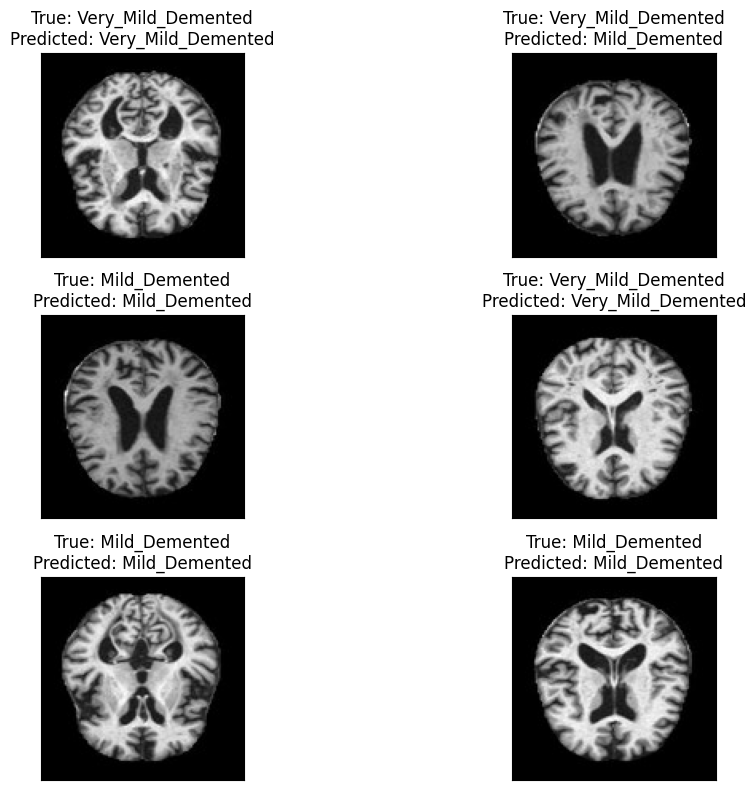

In [42]:
#Visualizations of test predicted vs. test true labels
fig,axes=plt.subplots(nrows=3,ncols=2,figsize=(12,8),subplot_kw={"xticks":[],"yticks":[]})

for i, ax in enumerate(axes.flat):
  ax.imshow(Xtest[i])
  ax.set_title(f"Predicted: {pred_test[i]}\nTrue: {y_test[i]}")
plt.tight_layout()
plt.show()

### Taking every 5th pixel to decrease overfitting:

In [43]:
N = 2360
Xval = Xtrain_reshaped[N:,::5]/255.0
Xtrain_reshaped = Xtrain_reshaped[:N,::5]/255.0
yval=ytrain[N:]
ytrain=ytrain[:N]
ytrain.shape,Xtrain_reshaped.shape,yval.shape

((2360,), (2360, 9831), (9,))

In [44]:
model=LogisticRegression(max_iter=5000)
model.fit(Xtrain_reshaped,ytrain)
pred=model.predict(Xtrain_reshaped)
accuracy_score(pred,ytrain)
#It is not good, the accuracy decreased drastically

0.45466101694915256

### Trying with resizing the data:

In [50]:
from skimage.transform import resize

new_size = (64, 64)

Xtrain_resized = np.array([resize(image, new_size) for image in Xtrain])
Xtest_resized = np.array([resize(image, new_size) for image in Xtest])

Xtrain_resized = Xtrain_resized / 255.0
Xtest_resized = Xtest_resized / 255.0

#we have to flatten the data again:
Xtrain_resized = Xtrain_resized.reshape(Xtrain_resized.shape[0], -1)
Xtest_resized= Xtest_resized.reshape(Xtest_resized.shape[0], -1)

In [51]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=28)
model.fit(Xtrain_resized, ytrain)

# Evaluate the model
pred_train = model.predict(Xtrain_resized)
train_accuracy = accuracy_score(pred_train, ytrain)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

Training Accuracy: 99.96%


In [52]:
pred_test = model.predict(Xtest_resized)
test_accuracy = accuracy_score(pred_test, ytest)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
#Does not improve the model

Test Accuracy: 78.58%


### Other option to reduce overfitting / improve the accuracy of the predictions is by using a deep learning model

### 7. Training a deep learning model:

In [72]:
#First we replace the name of the labels by numbers

CLASSES = dict(zip(['Non_Demented','Moderate_Demented','Mild_Demented', 'Very_Mild_Demented'],range(4)))

ytrain_num=pd.Series(ytrain)
ytrain_num=ytrain_num.replace(CLASSES)
ytrain_num.head()

ytest_num=pd.Series(ytest)
ytest_num=ytest_num.replace(CLASSES)
ytrain_num.head()

0    0
1    0
2    0
3    0
4    2
dtype: int64

In [73]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(Xtrain, ytrain_num, epochs=5, batch_size=32, validation_data=(Xtest, ytest_num))

#So, as we can see the overfitting is reduced significantly with just 5 epochs. If we increased it the overfitting would be even less. But of course it would take longer

Epoch 1/5
75/75 [==============================] - 54s 715ms/step - loss: 1.3724 - accuracy: 0.4331 - val_loss: 0.9276 - val_accuracy: 0.5987
Epoch 2/5
75/75 [==============================] - 61s 814ms/step - loss: 0.8175 - accuracy: 0.6408 - val_loss: 1.0282 - val_accuracy: 0.4924
Epoch 3/5
75/75 [==============================] - 50s 667ms/step - loss: 0.4906 - accuracy: 0.8333 - val_loss: 0.4941 - val_accuracy: 0.7943
Epoch 4/5
75/75 [==============================] - 56s 755ms/step - loss: 0.2680 - accuracy: 0.9278 - val_loss: 0.3259 - val_accuracy: 0.8954
Epoch 5/5
75/75 [==============================] - 55s 735ms/step - loss: 0.1348 - accuracy: 0.9738 - val_loss: 0.2552 - val_accuracy: 0.9174


In [74]:
pred_prob = model.predict(Xtest)

pred = np.argmax(pred_prob, axis=1) #To convert these probabilities to labels

19/19 [==============================] - 4s 174ms/step


In [75]:
ytest=list(ytest_num)
print(classification_report(ytest,pred))
#0--> Mild_Demented
#1--> Moderate_Demented
#2--> Non_Demented
#3--> Very_Mild_Demented

              precision    recall  f1-score   support

           0       0.93      0.84      0.88       195
           1       1.00      1.00      1.00         9
           2       0.94      0.99      0.97       181
           3       0.88      0.92      0.90       208

    accuracy                           0.92       593
   macro avg       0.94      0.94      0.94       593
weighted avg       0.92      0.92      0.92       593



### 8. Conclusion:

In conclusion, using the deep learning model proved to be the best option. While other models performed well on the training data, they exhibited significant overfitting when applied to the test data. This issue was effectively mitigated by employing the Keras deep learning model "Sequential".

For text data, traditional models might suffice, but when dealing with image data, it's better to use a deep learning model due to its superior ability to capture complex patterns and features. This was evident in our results, where the deep learning model outperformed our other approaches by a significant margin.

Moreover, the importance of using deep learning becomes even more critical when handling health-related datasets, such as our Alzheimer's dataset. Accurate and reliable models are essential in medical applications to ensure precise diagnostics and interventions.

Bibliograhy:
- Content from class
- Youtube video: https://www.youtube.com/watch?v=2OXV9MiATOY